In [0]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
! pip install linearmodels
from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS as fe # for fixed effects
import matplotlib.pyplot as plt

## Load Data

In [0]:
data = pd.read_excel('https://drive.google.com/uc?export=download&id=1J2-qDDCOzxpacT9HdCSfrpEdUqGXpoKX')

data = data.sort_values(by=['gvkey', 'fyear'])

data.head()

data['year'] = data['fyear']

**Variables:**

gvkey: firm id

at: total assets

capx: investment

che: cash

csho: Common Shares Outstanding

dlc: short-term debt

dltt: long-term debt

dvt: dividends

oiadp: operating income after depreciation

pstk: preferred stock

revt: revenue

prcc_f: price close

sic: industry code


# replace some missings to zero

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50060 entries, 0 to 50059
Data columns (total 16 columns):
gvkey       50060 non-null int64
datadate    50060 non-null datetime64[ns]
fyear       50060 non-null int64
at          49891 non-null float64
capx        48398 non-null float64
che         49884 non-null float64
csho        49163 non-null float64
dlc         49820 non-null float64
dltt        49780 non-null float64
dvt         49492 non-null float64
oiadp       49864 non-null float64
pstk        49700 non-null float64
revt        49865 non-null float64
prcc_f      46691 non-null float64
sic         50060 non-null int64
year        50060 non-null int64
dtypes: datetime64[ns](1), float64(11), int64(4)
memory usage: 6.5 MB


In [0]:
# get the index of rows where capx is negative or the value is missed
idx = data.loc[ (data['capx'].isnull()) | (data['capx']<0)].index

# replace value of capx at those rows by zero.
data.loc[idx, 'capx'] = 0

In [0]:
# Fill missing variables with zero
data[['dltt', 'dlc', 'pstk']] = data[['dltt', 'dlc', 'pstk']].apply(lambda x: x.fillna(0))

# calculate financial variables

In [0]:
data['debt'] = data['dlc'] + data['dltt']

In [0]:
data['equity'] = data['pstk'] + data['prcc_f']*data['csho']

In [0]:
# firm_value is the sum of equity and debt and leverage = debt / firm_value

### practice

data['firm_value']=data['debt']+data['equity']

data['leverage']=data['debt']/data['firm_value']


In [0]:
data.describe()

,gvkey,fyear,at,capx,che,csho,dlc,dltt,dvt,oiadp,pstk,revt,prcc_f,sic,year,debt,equity,firm_value,leverage
count,50060.000000,50060.000000,4.989100e+04,50060.000000,49884.000000,49163.000000,50060.000000,50060.000000,49492.000000,49864.000000,50060.000000,49865.000000,46691.000000,50060.000000,50060.000000,50060.000000,46543.000000,4.654300e+04,46543.000000
mean,47520.295565,2008.974531,1.691878e+04,280.650161,1924.123376,205.270520,1465.410494,2573.762342,149.581280,661.679214,36.732036,4870.749605,33.077049,4713.566760,2008.974531,4039.172836,6620.929920,1.066952e+04,0.247006
std,52491.522841,5.446955,1.092948e+05,739.382866,17228.374200,695.968007,17281.093095,13248.331892,637.692964,2458.176589,614.688501,12890.279074,107.533801,1861.686116,5.446955,27680.815567,19106.599940,4.025748e+04,0.235271
min,1004.000000,2000.000000,0.000000e+00,0.000000,-0.156000,0.000000,0.000000,0.000000,-665.655000,-16207.404000,-252.000000,-15009.328000,0.000100,100.000000,2000.000000,0.000000,0.000000,1.500000e-04,0.000000
25%,9299.000000,2004.000000,2.364600e+02,2.421750,15.448250,14.701500,0.100000,3.000000,0.000000,5.882750,0.000000,106.455000,7.920000,3490.000000,2004.000000,8.466000,141.668435,2.062293e+02,0.039953
50%,24396.000000,2009.000000,1.269421e+03,24.193500,77.716500,41.371000,10.018000,154.079500,2.518000,72.950000,0.000000,744.755000,20.410000,4841.000000,2009.000000,219.548000,822.923530,1.165885e+03,0.188019
75%,65090.000000,2014.000000,6.177509e+03,173.256000,389.558750,130.908000,154.568500,1198.050000,55.702750,398.674000,0.000000,3318.765000,38.756000,6020.000000,2014.000000,1470.606000,4177.238730,6.020374e+03,0.390371
max,259503.000000,2018.000000,3.065553e+06,9830.851000,623959.820000,29058.361000,575319.394000,542569.195000,67643.805000,91996.871000,70664.000000,226247.000000,11650.000000,9997.000000,2018.000000,889300.000000,467092.875000,1.036340e+06,1.000000


Take the difference of consecutive years. Mark if it's not equal to one

In [0]:
data.describe()

,gvkey,fyear,at,capx,che,csho,dlc,dltt,dvt,oiadp,pstk,revt,prcc_f,sic,year,debt,equity,firm_value,leverage
count,50060.000000,50060.000000,4.989100e+04,50060.000000,49884.000000,49163.000000,50060.000000,50060.000000,49492.000000,49864.000000,50060.000000,49865.000000,46691.000000,50060.000000,50060.000000,50060.000000,46543.000000,4.654300e+04,46543.000000
mean,47520.295565,2008.974531,1.691878e+04,280.650161,1924.123376,205.270520,1465.410494,2573.762342,149.581280,661.679214,36.732036,4870.749605,33.077049,4713.566760,2008.974531,4039.172836,6620.929920,1.066952e+04,0.247006
std,52491.522841,5.446955,1.092948e+05,739.382866,17228.374200,695.968007,17281.093095,13248.331892,637.692964,2458.176589,614.688501,12890.279074,107.533801,1861.686116,5.446955,27680.815567,19106.599940,4.025748e+04,0.235271
min,1004.000000,2000.000000,0.000000e+00,0.000000,-0.156000,0.000000,0.000000,0.000000,-665.655000,-16207.404000,-252.000000,-15009.328000,0.000100,100.000000,2000.000000,0.000000,0.000000,1.500000e-04,0.000000
25%,9299.000000,2004.000000,2.364600e+02,2.421750,15.448250,14.701500,0.100000,3.000000,0.000000,5.882750,0.000000,106.455000,7.920000,3490.000000,2004.000000,8.466000,141.668435,2.062293e+02,0.039953
50%,24396.000000,2009.000000,1.269421e+03,24.193500,77.716500,41.371000,10.018000,154.079500,2.518000,72.950000,0.000000,744.755000,20.410000,4841.000000,2009.000000,219.548000,822.923530,1.165885e+03,0.188019
75%,65090.000000,2014.000000,6.177509e+03,173.256000,389.558750,130.908000,154.568500,1198.050000,55.702750,398.674000,0.000000,3318.765000,38.756000,6020.000000,2014.000000,1470.606000,4177.238730,6.020374e+03,0.390371
max,259503.000000,2018.000000,3.065553e+06,9830.851000,623959.820000,29058.361000,575319.394000,542569.195000,67643.805000,91996.871000,70664.000000,226247.000000,11650.000000,9997.000000,2018.000000,889300.000000,467092.875000,1.036340e+06,1.000000


In [0]:
temp = data.groupby('gvkey')['fyear'].diff()

idxyr = temp[(temp!=1) & (~temp.isnull())].index

Create r_capx equal to investment normalized by previous year's total assets

In [0]:
# groupby gvkey and find lagged value of at
data['lag_at'] = data.groupby('gvkey')['at'].shift()

# for rows where years are not consecutive, set lagged value of the later year be np.nan 
# (to parallel with L.var in stata)
data.loc[idxyr, 'lag_at'] = np.nan

idx = data.loc[data['lag_at']>0].index

data.loc[idx, 'r_capx'] = data.loc[idx, 'capx']/data.loc[idx, 'lag_at']

Create r_oiadp equal to operating profits normalized by the average of this year and previous year's assets

In [0]:
data['at_avg'] = (data['lag_at'] + data['at'])/2

In [0]:
idx = data.loc[data['at_avg']>0].index

data.loc[idx, 'r_oiadp'] = data.loc[idx, 'oiadp']/data.loc[idx, 'at_avg']

Create g_revt equal to growth rate in log revenue

In [0]:
# g_revt = growth rate in log revenue

### practice

data['lag_revt'] = data.groupby('gvkey')['revt'].shift()

data.loc[idxyr, 'lag_revt'] = np.nan

idx = data.loc[(data['revt']>0)  & (data['lag_revt']>0)].index

data.loc[idx, 'g_revt']=np.log(data.loc[idx, 'revt'])- np.log(data.loc[idx, 'lag_revt'])




# winsorize

Winsorize by removing top 1% and bottom 1% outliers

In [0]:
targets = ['r_capx', 'r_oiadp', 'g_revt']

# values slightly larger than stata log file from 90% quantile
data[targets].describe(percentiles=[.01,.05,.1,.25,.5,.75,.90,.95,.99])

,r_capx,r_oiadp,g_revt
count,47197.000000,47147.000000,46491.000000
mean,0.097546,-0.096659,0.057960
std,9.784711,9.254864,0.361383
min,0.000000,-1618.000000,-6.350764
1%,0.000000,-0.996666,-0.907966
5%,0.000227,-0.252477,-0.309536
10%,0.001204,-0.071796,-0.164192
25%,0.008731,0.018290,-0.032744
50%,0.028159,0.059394,0.053045
75%,0.060111,0.110241,0.146442


In [0]:
def winsor(series):
    col=series.copy(deep=True)
    
    q99 = col.quantile(.99)
    q01 = col.quantile(.01)

    col.loc[col > q99] = q99
    col.loc[col < q01] = q01
    
    return col

In [0]:
newcols = [i+'_w' for i in targets] # add "_w" suffixes for each string in targets (python iterator)

data[newcols] = data[targets].apply(winsor)

# create lead variable for sales growth 

In [0]:
data['r_oiadp_lead1'] = data.groupby('gvkey')['r_oiadp_w'].shift(-1)

# pooled ols

In [0]:
exog_vars = ['leverage','g_revt_w','r_capx_w']

Sector is the first two digits of SIC code

In [0]:
# pooledOLS and panelOLS functions only accept dataframe with multiindex
# entity effect = sic2
# time effect = fyear
# entity effect must be defined as the outer index

data.set_index(['gvkey', 'fyear'], inplace=True)

In [0]:
exog = sm.add_constant(data[exog_vars])

mod = PooledOLS(data['r_oiadp_lead1'], exog)

pooled_res = mod.fit()

print(pooled_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:          r_oiadp_lead1   R-squared:                        0.0183
Estimator:                  PooledOLS   R-squared (Between):              0.0140
No. Observations:               41049   R-squared (Within):               0.0268
Date:                Thu, Jan 30 2020   R-squared (Overall):              0.0183
Time:                        20:40:29   Log-likelihood                 1.499e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      254.59
Entities:                        2509   P-value                           0.0000
Avg Obs:                       16.361   Distribution:                 F(3,41045)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             254.59
                            

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


# with year fixed effects

In [0]:
mod = fe(data['r_oiadp_lead1'], exog, time_effects=True)

fe_yr = mod.fit()

print(fe_yr)

/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:          r_oiadp_lead1   R-squared:                        0.0184
Estimator:                   PanelOLS   R-squared (Between):              0.0145
No. Observations:               41049   R-squared (Within):               0.0258
Date:                Thu, Jan 30 2020   R-squared (Overall):              0.0183
Time:                        20:40:29   Log-likelihood                 1.504e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      256.64
Entities:                        2509   P-value                           0.0000
Avg Obs:                       16.361   Distribution:                 F(3,41029)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             256.64
                            

# with Firm Fixed Effects

In [0]:
#data.reset_index(inplace=True)

#data.set_index(['gvkey', 'fyear'], inplace=True)

In [0]:
### practice

mod = fe(data['r_oiadp_lead1'], exog, entity_effects=True)

fe_firm = mod.fit()

print(fe_firm)



                          PanelOLS Estimation Summary                           
Dep. Variable:          r_oiadp_lead1   R-squared:                        0.0378
Estimator:                   PanelOLS   R-squared (Between):             -0.0066
No. Observations:               41049   R-squared (Within):               0.0378
Date:                Thu, Jan 30 2020   R-squared (Overall):              0.0081
Time:                        20:40:29   Log-likelihood                 3.985e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      504.12
Entities:                        2509   P-value                           0.0000
Avg Obs:                       16.361   Distribution:                 F(3,38537)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             504.12
                            

/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


# with Firm and Year Fixed Effects

In [0]:
### practice


mod = fe(data['r_oiadp_lead1'], exog, entity_effects=True, time_effects=True)

fe_yr_firm = mod.fit()

print(fe_yr_firm)


/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:          r_oiadp_lead1   R-squared:                        0.0367
Estimator:                   PanelOLS   R-squared (Between):             -0.0054
No. Observations:               41049   R-squared (Within):               0.0377
Date:                Thu, Jan 30 2020   R-squared (Overall):              0.0090
Time:                        20:40:30   Log-likelihood                 3.997e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      489.09
Entities:                        2509   P-value                           0.0000
Avg Obs:                       16.361   Distribution:                 F(3,38521)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             489.09
                            

# First difference

In [0]:
### practice

# hint: use diff()

mod_firstdiff = data.groupby('gvkey')[['r_oiadp_lead1'] + exog_vars ].diff()

exog = sm.add_constant(mod_firstdiff[exog_vars])

mod = PooledOLS(mod_firstdiff['r_oiadp_lead1'], exog)
# If you're in Section 0501: I made a mistake here and used data instead of mod_firstdiff, the correct coefficient should be negative for capx in FD

firstdiff = mod.fit()

print(firstdiff)



                          PooledOLS Estimation Summary                          
Dep. Variable:          r_oiadp_lead1   R-squared:                        0.0019
Estimator:                  PooledOLS   R-squared (Between):             -0.0162
No. Observations:               38433   R-squared (Within):               0.0021
Date:                Thu, Jan 30 2020   R-squared (Overall):              0.0019
Time:                        20:40:32   Log-likelihood                 3.835e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      24.480
Entities:                        2504   P-value                           0.0000
Avg Obs:                       15.349   Distribution:                 F(3,38429)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             24.480
                            

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


# Plot the coefficients of OLS, FE, and FD in a bar chart

In [0]:
# define dataframe res to save parameters of each regression

res = pooled_res.params # res is pd.Series here

res.name = 'OLS'

res = res.to_frame() # transfer res to pd.DataFrame

res['FE_year'] = fe_yr.params

res['FE_firm'] = fe_firm.params

res['FE_firm_year'] = fe_yr_firm.params

res['FD'] = firstdiff.params

In [0]:
res

,OLS,FE_year,FE_firm,FE_firm_year,FD
const,0.034728,0.034000,0.058037,0.056998,0.000007
leverage,-0.014587,-0.013398,-0.077880,-0.076416,-0.005572
g_revt_w,0.070401,0.072315,0.057733,0.059296,-0.007073
r_capx_w,0.185916,0.193065,0.031177,0.044159,-0.069939


Text(0.5, 0, 'models')

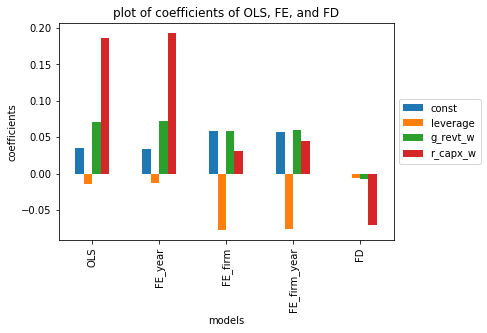

In [0]:
# restructure the dataframe to make columns indices and make indices columns
res.unstack().unstack().plot.bar()

# plot by pandas plot function 
# -- functions of matplotlib is also applicable here because pandas plot is built up on matplotlib
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('plot of coefficients of OLS, FE, and FD')

plt.ylabel('coefficients')

plt.xlabel('models')

First difference and fixed effects are very different. Maybe one of the models is wrong. For example, if investment takes many years to take effect, then first difference model is misspecified by taking difference between adjacent two years

# FD and FE are equivalent when two periods

In [0]:
data.head()

datadate       at    capx  ...  r_oiadp_w  g_revt_w  r_oiadp_lead1
gvkey fyear                              ...                                    
1004  2000  2001-05-31  701.854  13.134  ...        NaN       NaN       0.006673
      2001  2002-05-31  710.199  12.112  ...   0.006673 -0.313904       0.005116
      2002  2003-05-31  686.621   9.930  ...   0.005116 -0.052032       0.029817
      2003  2004-05-31  709.292  10.286  ...   0.029817  0.072544       0.046928
      2004  2005-05-31  732.230  13.033  ...   0.046928  0.137220       0.073236

[5 rows x 28 columns]

In [0]:
# practice
# use only year 2016 and 2017

data2 = data.loc[(data['year']==2016) | (data['year']==2017) ]

# first do fixed effects

exog = sm.add_constant(data2[exog_vars])

mod = fe(data2['r_oiadp_lead1'], exog, entity_effects=True)

fe_firm = mod.fit()

print(fe_firm)


                          PanelOLS Estimation Summary                           
Dep. Variable:          r_oiadp_lead1   R-squared:                        0.0060
Estimator:                   PanelOLS   R-squared (Between):             -0.0079
No. Observations:                4670   R-squared (Within):               0.0060
Date:                Thu, Jan 30 2020   R-squared (Overall):             -0.0061
Time:                        21:02:39   Log-likelihood                    8958.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4.4661
Entities:                        2451   P-value                           0.0039
Avg Obs:                       1.9053   Distribution:                  F(3,2216)
Min Obs:                       1.0000                                           
Max Obs:                       2.0000   F-statistic (robust):             4.4661
                            

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [0]:
# first difference

mod_firstdiff = data2.groupby('gvkey')[['r_oiadp_lead1'] + exog_vars ].diff()

exog = sm.add_constant(mod_firstdiff[exog_vars])

mod = PooledOLS(mod_firstdiff['r_oiadp_lead1'], exog)

firstdiff = mod.fit()

print(firstdiff)



                          PooledOLS Estimation Summary                          
Dep. Variable:          r_oiadp_lead1   R-squared:                        0.0061
Estimator:                  PooledOLS   R-squared (Between):              0.0061
No. Observations:                2219   R-squared (Within):               0.0000
Date:                Thu, Jan 30 2020   R-squared (Overall):              0.0061
Time:                        21:02:51   Log-likelihood                    2662.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4.5334
Entities:                        2219   P-value                           0.0036
Avg Obs:                       1.0000   Distribution:                  F(3,2215)
Min Obs:                       1.0000                                           
Max Obs:                       1.0000   F-statistic (robust):             4.5334
                            

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [0]:
res = firstdiff.params 

res.name = 'First_difference'

res = res.to_frame() 

res['FE_firm'] = fe_firm.params

res

,First_difference,FE_firm
const,-0.010769,0.052002
leverage,-0.080175,-0.078433
g_revt_w,0.035869,0.037922
r_capx_w,0.321010,0.325201
